# Entrenamiento modelo para detección de Phising a partir de una URL

Importamos la librerías necesarias para la realización del proyecto

In [26]:
import os
import tempfile
from pyspark.sql import SparkSession

# Detectar automáticamente Java 17 o 11 (PySpark 4.1.0+ requiere Java 17+)
if 'JAVA_HOME' not in os.environ:
    try:
        # Intentar Java 17 primero (requerido para PySpark 4.1.0+)
        java_home_17 = os.popen('/usr/libexec/java_home -v 17 2>/dev/null').read().strip()
        if java_home_17:
            os.environ['JAVA_HOME'] = java_home_17
        else:
            # Si no hay Java 17, intentar Java 11
            java_home_11 = os.popen('/usr/libexec/java_home -v 11 2>/dev/null').read().strip()
            if java_home_11:
                os.environ['JAVA_HOME'] = java_home_11
    except:
        pass

# Path dinámico para warehouse (compatible con cualquier OS)
warehouse_dir = os.path.join(tempfile.gettempdir(), "spark-warehouse")
os.makedirs(warehouse_dir, exist_ok=True)

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Ejemplo pySparkSQL") \
    .config("spark.sql.warehouse.dir", f"file://{warehouse_dir}") \
    .config("spark.hadoop.fs.viewfs.impl", "org.apache.hadoop.fs.LocalFileSystem") \
    .getOrCreate()

sc = spark.sparkContext

25/12/31 14:48:41 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [27]:
%matplotlib inline 
from pyspark.sql import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.sql.types import NumericType

from pyspark.ml import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.feature import *
from pyspark.ml.evaluation import *
from pyspark.ml.classification import *

Guardamos el path del csv

In [28]:
csv_path = os.path.join(os.getcwd(), "phishing_features.csv")
print(f"CSV path: {csv_path}")

CSV path: /Users/sancheziii/Documents/School/computacion avanzada/URL_phising_detector/phishing_features.csv


Cargamos el csv en un dataframe e imprimimos el schema del mismo

In [29]:
df = spark.read.csv(csv_path, inferSchema=True, header=True)
print("Elementos en DataFrame a partir de datos/personas.csv: " + str(df.count()) + "\nEsquema: ")
print (df.printSchema())
type(df)

Elementos en DataFrame a partir de datos/personas.csv: 160064
Esquema: 
root
 |-- url: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- url_length: integer (nullable = true)
 |-- num_dots: integer (nullable = true)
 |-- has_https: integer (nullable = true)
 |-- has_ip: integer (nullable = true)
 |-- num_subdirs: integer (nullable = true)
 |-- num_params: integer (nullable = true)
 |-- suspicious_words: integer (nullable = true)
 |-- tld: string (nullable = true)
 |-- special_char_count: integer (nullable = true)
 |-- digits_count: integer (nullable = true)
 |-- entropy: double (nullable = true)

None


pyspark.sql.classic.dataframe.DataFrame

Lo primero que vamos a comprobar es si nuestro dataset está desbalanceado o no. Al tener un problema binario, lo ideal sería tener un 50% de ejemplos de cada clase. En el caso de que la diferencia sea muy obvia, tendremos que aplicar ciertas medidas para que no afecte al rendimiento del modelo

In [30]:
count_1 = df.filter(df['label'] == 1).count()
count_0 = df.filter(df['label'] == 0).count()
total = df.count()


perc_0 = (count_0 / total) * 100
perc_1 = (count_1 / total) * 100

print()

print(f"Benign (0): {count_0} records ({perc_0:.2f}%)")
print(f"Phishing (1): {count_1} records ({perc_1:.2f}%)")


Benign (0): 820 records (0.51%)
Phishing (1): 159244 records (99.49%)


Comprobamos que en efecto, nuestro dataset está desbalanceado

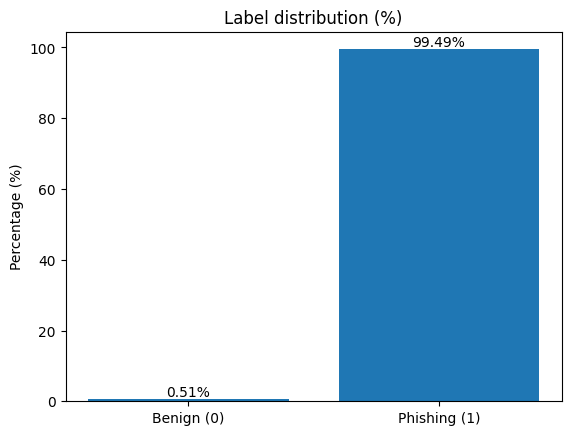

In [31]:
labels = ["Benign (0)", "Phishing (1)"]
percentages = [perc_0, perc_1]

plt.figure()
bars = plt.bar(labels, percentages)
plt.ylabel("Percentage (%)")
plt.title("Label distribution (%)")

# Añadir el texto del porcentaje encima de cada barra
for bar, perc in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{perc:.2f}%",
        ha="center",
        va="bottom"
    )

plt.show()

A continuación, vamos a buscar si nuestro dataset posee valores nulos. Muchos modelos no aceptan valores nulos en su entrenamiento. Si no los tratamos, probablemente nos salte un error y no podremos continuar hasta que lo solucionemos. Si, por lo que sea, el modelo acepta los valores nulos, estos pueden suponer un problema que afecta al rendimiento del modelo ya que perderemos información que puede ser valiosa en el entrenamiento o podemos caer en sesgos. Buscamos valores nulos en el dataset para tratarlo de forma adecuada.

In [32]:
condition = reduce(
    lambda a, b: a | b,
    [col(c).isNull() for c in df.columns]
)

n = df.filter(condition).count()
df.filter(condition).show(n, truncate=False)

+------------------------+-----+----------+--------+---------+------+-----------+----------+----------------+----+------------------+------------+------------------+
|url                     |label|url_length|num_dots|has_https|has_ip|num_subdirs|num_params|suspicious_words|tld |special_char_count|digits_count|entropy           |
+------------------------+-----+----------+--------+---------+------+-----------+----------+----------------+----+------------------+------------+------------------+
|https://verify-att.app./|1    |24        |2       |1        |0     |3          |0         |1               |NULL|1                 |0           |3.688721875540867 |
|google.com              |0    |10        |1       |0        |0     |0          |0         |0               |NULL|0                 |0           |2.6464393446710157|
|youtube.com             |0    |11        |1       |0        |0     |0          |0         |0               |NULL|0                 |0           |3.095795255000934 |
|wik

Vemos que hay varios registros cuyo tld (dominio) es nulo. Vamos a recorrer todas las url cuyo tld sea nulo y vamos a asignarles su 

In [33]:
df = df.withColumn(
    "tld",
    when(col("tld").isNull(),    
        element_at(split(lit(col("url")), r"\."), -1).alias("tld")
    ).otherwise(col("tld"))
)

df = df.cache()
df.count()

df.filter((col("url") == 'google.com') | (col('url') == 'wikipedia.org') | (col('url') == 'safeexample99.net')).show(truncate=False)




+-----------------+-----+----------+--------+---------+------+-----------+----------+----------------+---+------------------+------------+------------------+
|url              |label|url_length|num_dots|has_https|has_ip|num_subdirs|num_params|suspicious_words|tld|special_char_count|digits_count|entropy           |
+-----------------+-----+----------+--------+---------+------+-----------+----------+----------------+---+------------------+------------+------------------+
|google.com       |0    |10        |1       |0        |0     |0          |0         |0               |com|0                 |0           |2.6464393446710157|
|wikipedia.org    |0    |13        |1       |0        |0     |0          |0         |0               |org|0                 |0           |3.334679141051595 |
|safeexample99.net|0    |17        |1       |0        |0     |0          |0         |0               |net|0                 |2           |3.381580488309163 |
+-----------------+-----+----------+--------+-------

25/12/31 14:49:07 WARN CacheManager: Asked to cache already cached data.


Vemos en tres de URL antes filtradas que ya no tienen tld nulo

### Atención: es importante darle un valor numérico a cada dominio (los modelos no aceptan strings)

In [ ]:

from pyspark.sql.functions import countDistinct

unique_tlds = df.select("tld").distinct().count()
print(f"Total de TLDs únicos en el dataset: {unique_tlds}")

print("\nTLDs más frecuentes:")
tld_counts = df.groupBy("tld").count().orderBy(col("count").desc())
tld_counts.show(20, truncate=False)

print("\nNOTA: La conversión de TLD a numérico se realizará dentro de la Pipeline")
print("para asegurar que el StringIndexer aprenda solo del conjunto de entrenamiento.")

Total de TLDs únicos en el dataset: 538

TLDs más frecuentes:
+------+-----+
|tld   |count|
+------+-----+
|com   |32706|
|ru    |15011|
|202   |3745 |
|34    |3551 |
|227   |3312 |
|de    |2783 |
|app   |2758 |
|dev   |2691 |
|me    |2549 |
|232   |2262 |
|228   |2262 |
|ly    |2185 |
|to    |2037 |
|page  |1941 |
|199   |1876 |
|info  |1429 |
|online|1328 |
|org   |1286 |
|io    |1203 |
|net   |1190 |
+------+-----+
only showing top 20 rows

NOTA: La conversión de TLD a numérico se realizará dentro de la Pipeline
para asegurar que el StringIndexer aprenda solo del conjunto de entrenamiento.


## Implementación de Modelos

Dividimos nuestros datos en train y test

In [35]:
seed = 12418
train, test_total = df.randomSplit([0.8, 0.2], seed=seed)

train.cache()
test_total.cache()

train_count = train.count() 
test_count_total = test_total.count()

print(f"Train count: {train_count}")
print(f"Test count: {test_count_total}")

Train count: 128146
Test count: 31918


In [36]:
val, test = df.randomSplit([0.5, 0.5], seed=seed)

val.cache()
test.cache()

val_count = val.count()
test_count = test.count()

print(f"Validation count: {val_count}")
print(f"Test count: {test_count}")


Validation count: 80284
Test count: 79780


In [ ]:

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

tld_indexer = StringIndexer(
    inputCol="tld",
    outputCol="tld_indexed", 
    handleInvalid="keep"  
)


feature_cols = ['url_length', 'num_dots', 'has_https', 'has_ip', 'num_subdirs', 
                'num_params', 'suspicious_words', 'tld_indexed', 'special_char_count', 
                'digits_count', 'entropy']

assembler = VectorAssembler(
    inputCols=feature_cols, 
    outputCol="features"
)

logistic_regression = LogisticRegression(
    maxIter=20, 
    regParam=0.01, 
    featuresCol='features', 
    labelCol='label'
)


pipeline = Pipeline(stages=[tld_indexer, assembler, logistic_regression])

print("Pipeline creada con los siguientes stages:")
print("1. StringIndexer (TLD -> numérico)")
print("2. VectorAssembler (features -> vector)")
print("3. LogisticRegression (modelo)")
print("\nEntrenando pipeline...")


pipeline_model = pipeline.fit(train)


tld_indexer_model = pipeline_model.stages[0]  
tld_labels = tld_indexer_model.labels
print("\nMapeo de TLD -> Índice numérico (aprendido del conjunto de entrenamiento):")
print("=" * 60)
for idx, tld in enumerate(tld_labels[:20]):  # Mostrar los primeros 20
    print(f"{tld:25s} -> {idx}")
if len(tld_labels) > 20:
    print(f"... y {len(tld_labels) - 20} TLDs más")
print(f"\nTotal de TLDs únicos aprendidos: {len(tld_labels)}")
print("=" * 60)

print("\nAplicando pipeline a datos de validación...")
prediction = pipeline_model.transform(val)


evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

f1_score = evaluator.evaluate(prediction)
print(f"\nF1-Score: {f1_score:.4f}")

print("\nEjemplos de predicciones (primeras 10 filas):")
prediction.select("url", "label", "prediction", "probability").show(10, truncate=False)


Pipeline creada con los siguientes stages:
1. StringIndexer (TLD -> numérico)
2. VectorAssembler (features -> vector)
3. LogisticRegression (modelo)

Entrenando pipeline...

Mapeo de TLD -> Índice numérico (aprendido del conjunto de entrenamiento):
com                       -> 0
ru                        -> 1
202                       -> 2
34                        -> 3
227                       -> 4
de                        -> 5
app                       -> 6
dev                       -> 7
me                        -> 8
228                       -> 9
232                       -> 10
ly                        -> 11
to                        -> 12
page                      -> 13
199                       -> 14
info                      -> 15
org                       -> 16
online                    -> 17
io                        -> 18
net                       -> 19
... y 502 TLDs más

Total de TLDs únicos aprendidos: 522

Aplicando pipeline a datos de validación...

F1-Score: 0.9924



In [38]:
cm_df = prediction.groupBy("label", "prediction").count()

cm_df.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       1.0|79877|
|    0|       1.0|  407|
+-----+----------+-----+



Aplicamos medidas para que este desbalance no nos afecte en exceso

In [22]:
# Todo: MEDIDAS PARA TRATAR DESBALANCEO DE CLASES